In [1]:
#Inital imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
from lifetimes.plotting import plot_period_transactions, plot_calibration_purchases_vs_holdout_purchases
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from datetime import timedelta
from datetime import datetime
from dateutil import parser
from sklearn.metrics import mean_squared_error

In [2]:
#Load in our pre-prepared dataframe
lifetimes_object_df = pd.read_csv("data/lifetimes_object_df.csv")
lifetimes_object_df.head(5)

,order_id,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value
0,00e7ee1b050b8499577073aeb2a297a1,861eff4711a542e4b93843c6dd7febb0,delivered,2017-05-16,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,146.87
1,29150127e6685892b6eab3eec79f59c7,290c77bc529b7ac935b93aa66c333dc3,delivered,2018-01-12,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,335.48
2,b2059ed67ce144a36e2aa97d2c9e9ad2,060e732b5b29e8181a18229c7b0b2b5e,delivered,2018-05-19,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,157.73
3,951670f92359f4fe4a63112aa7306eba,259dac757896d24d7702b9acbbff3f3c,delivered,2018-03-13,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,173.30
4,6b7d50bd145f6fc7f33cebabd7e49d0f,345ecd01c38d18a9036ed96c73b8d066,delivered,2018-07-29,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,252.25


### Data cleaning

In [3]:
lifetimes_object_df[lifetimes_object_df["payment_value"]<=0]

,order_id,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value


In [4]:
lifetimes_object_df.shape

(98206, 9)

In [5]:
#It seems we only have 3,345 repeat buyers, this could be a major issue.
len(list(lifetimes_object_df.customer_unique_id)) - len(set(list(lifetimes_object_df.customer_unique_id)))

3217

### Data wrangling into lifetimes object

In [74]:
#Load in our data wrangler
from lifetimes.utils import summary_data_from_transaction_data

In [7]:
summary = summary_data_from_transaction_data(transactions=lifetimes_object_df,customer_id_col='customer_unique_id',
                                             datetime_col='order_purchase_timestamp',monetary_value_col='payment_value',observation_period_end='2018-10-17')
summary

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,160.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,163.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,586.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,370.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,337.0,0.0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,496.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,311.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,617.0,0.0


In [8]:
#We have less than 3% of customers who are repeat purchasers
summary.frequency.value_counts(normalize=True)

0.0     0.978261
1.0     0.020097
2.0     0.001305
3.0     0.000189
4.0     0.000063
5.0     0.000053
6.0     0.000021
15.0    0.000011
Name: frequency, dtype: float64

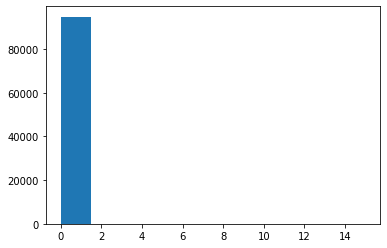

In [9]:
plt.hist(summary.frequency);

### Split of Training and Test Dataset

In [10]:
#Import holdout 
from lifetimes.utils import calibration_and_holdout_data

In [11]:
# days to preserve for evaluation
t_evaluation = 240                                         

#save the end of our data set observation
max_obs_date = lifetimes_object_df["order_purchase_timestamp"].max()
print("max transaction date observed:", max_obs_date)
#convert to date-time
max_obs_date = parser.parse(max_obs_date)

#save the end of our calibaration observation
max_calib_date = max_obs_date - timedelta(days=t_evaluation)
print("max calibration date observed:", max_calib_date)

df_ch = calibration_and_holdout_data(
        transactions = lifetimes_object_df, 
        customer_id_col='customer_unique_id',
        datetime_col='order_purchase_timestamp',
        monetary_value_col='payment_value',
        calibration_period_end = max_calib_date, 
        observation_period_end = max_obs_date, 
        freq = "D")
df_ch

max transaction date observed: 2018-09-03
max calibration date observed: 2018-01-06 00:00:00


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,0.0,0.0,302.0,0.0,0.0,0.0,240.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,86.0,0.0,0.0,0.0,240.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,53.0,0.0,0.0,0.0,240.0
0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,308.0,0.0,0.0,0.0,240.0
0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,172.0,0.0,0.0,0.0,240.0
...,...,...,...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,0.0,0.0,10.0,0.0,0.0,0.0,240.0
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,212.0,0.0,0.0,0.0,240.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,27.0,0.0,0.0,0.0,240.0


###  1.0 BG/NBD model
Model features
- Uncleaned data
Model results
- Terrrible
- Our model is way off because we have such an imbalence of customers who never made a repeat purchase.
Next steps
- Drop customers with less than 2 orders

In [12]:
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(
        frequency = df_ch["frequency_cal"], 
        recency = df_ch["recency_cal"], 
        T = df_ch["T_cal"],   
        weights = None,  
        verbose = True,)

Optimization terminated successfully.
         Current function value: 0.065817
         Iterations: 60
         Function evaluations: 63
         Gradient evaluations: 63


<lifetimes.BetaGeoFitter: fitted with 44463 subjects, a: 1.85, alpha: 55.22, b: 0.32, r: 0.02>

In [76]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.128861,0.169484,0.796672,1.461051
alpha,135.016045,27.417765,81.277224,188.754865
a,1.816854,0.797437,0.253877,3.379831
b,0.254597,0.120486,0.018444,0.490750


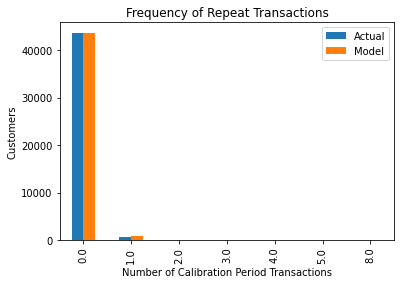

In [14]:
plot_period_transactions(bgf);

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

<Figure size 504x504 with 0 Axes>

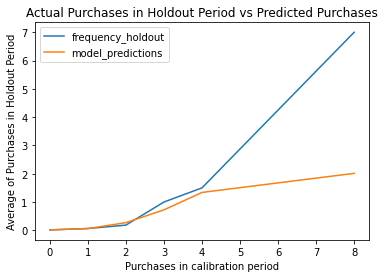

In [15]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7))
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch)

In [16]:
#Our model is way off because we have such an imbalence of customers who never made a repeat purchase.

###  2.0 BG/NBD model
Model features
- Removed all customers with less than 2 purchases

In [17]:
#create a list of repeat purchasers
repeat_purchaser_ids = list(summary[summary["frequency"] >= 1].index)

In [18]:
#subset our transaction data to just repeat purchasers
repeat_lifetimes_object_df = lifetimes_object_df[lifetimes_object_df["customer_unique_id"].isin(repeat_purchaser_ids) == True]

In [19]:
len(list(repeat_lifetimes_object_df["customer_unique_id"].unique()))

2065

In [20]:
# days to preserve for evaluation
t_evaluation = 240                                         

#save the end of our data set observation
max_obs_date = repeat_lifetimes_object_df["order_purchase_timestamp"].max()
print("max transaction date observed:", max_obs_date)
#convert to date-time
max_obs_date = parser.parse(max_obs_date)

#save the end of our calibaration observation
max_calib_date = max_obs_date - timedelta(days=t_evaluation)
print("max calibration date observed:", max_calib_date)

df_ch = calibration_and_holdout_data(
        transactions = lifetimes_object_df, 
        customer_id_col='customer_unique_id',
        datetime_col='order_purchase_timestamp',
        monetary_value_col='payment_value',
        calibration_period_end = max_calib_date, 
        observation_period_end = max_obs_date, 
        freq = "D")
df_ch

max transaction date observed: 2018-09-03
max calibration date observed: 2018-01-06 00:00:00


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,0.0,0.0,302.0,0.0,0.0,0.0,240.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,86.0,0.0,0.0,0.0,240.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,53.0,0.0,0.0,0.0,240.0
0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,308.0,0.0,0.0,0.0,240.0
0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,172.0,0.0,0.0,0.0,240.0
...,...,...,...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,0.0,0.0,10.0,0.0,0.0,0.0,240.0
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,212.0,0.0,0.0,0.0,240.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,27.0,0.0,0.0,0.0,240.0


In [21]:
#class to return a calibration and holdout df
class df_ch():
    def __init__(self, eval_period=None,transaction_df=None,purchase_timestamp_col=None,customer_id_col=None,datetime_col=None,monetary_value_col=None):
        #initialized attributes
        self.eval_period = eval_period
        self.transaction_df = transaction_df
        self.purchase_timestamp_col=purchase_timestamp_col
        self.customer_id_col=customer_id_col
        self.datetime_col=datetime_col
        self.monetary_value_col=monetary_value_col
        #save off more attributes
        self.max_obs_date = parser.parse(transaction_df[purchase_timestamp_col].max())
        self.max_calib_date = self.max_obs_date - timedelta(days=eval_period)
    def df_ch_getdf(self):
        df = calibration_and_holdout_data(
        transactions = self.transaction_df, 
        customer_id_col=self.customer_id_col,
        datetime_col=self.datetime_col,
        monetary_value_col=self.monetary_value_col,
        calibration_period_end = self.max_calib_date, 
        observation_period_end = self.max_obs_date, 
        freq = "D")
        return df
        

In [39]:
#testing new class
ch_2 = df_ch(eval_period=240,transaction_df=repeat_lifetimes_object_df,purchase_timestamp_col='order_purchase_timestamp',
                   customer_id_col='customer_unique_id',datetime_col='order_purchase_timestamp',
                   monetary_value_col='payment_value'
                  )

In [41]:
ch_2.df_ch_getdf()

240

In [44]:
df_ch_2 = ch_2.df_ch_getdf()
df_ch_2

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_unique_id,,,,,,,
004288347e5e88a27ded2bb23747066c,0.0,0.0,163.0,0.00,1.0,103.280000,240.0
004b45ec5c64187465168251cd1c9c2f,0.0,0.0,127.0,0.00,1.0,49.850000,240.0
011b4adcd54683b480c4d841250a987f,0.0,0.0,137.0,0.00,1.0,149.880000,240.0
012452d40dafae4df401bced74cdb490,0.0,0.0,202.0,0.00,1.0,340.070000,240.0
013f4353d26bb05dc6652f1269458d8d,1.0,4.0,43.0,164.04,0.0,0.000000,240.0
...,...,...,...,...,...,...,...
fe59d5878cd80080edbd29b5a0a4e1cf,2.0,76.0,213.0,39.60,0.0,0.000000,240.0
fe81bb32c243a86b2f86fbf053fe6140,1.0,9.0,76.0,63.78,3.0,487.733333,240.0
fed519569d16e690df6f89cb99d4e682,0.0,0.0,17.0,0.00,1.0,110.260000,240.0


In [34]:
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(
        frequency = df_ch_2["frequency_cal"], 
        recency = df_ch_2["recency_cal"], 
        T = df_ch_2["T_cal"],   
        weights = None,  
        verbose = True,)

Optimization terminated successfully.
         Current function value: 0.095057
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31


<lifetimes.BetaGeoFitter: fitted with 1384 subjects, a: 1.82, alpha: 135.02, b: 0.25, r: 1.13>

In [35]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.128861,0.169484,0.796672,1.461051
alpha,135.016045,27.417765,81.277224,188.754865
a,1.816854,0.797437,0.253877,3.379831
b,0.254597,0.120486,0.018444,0.490750


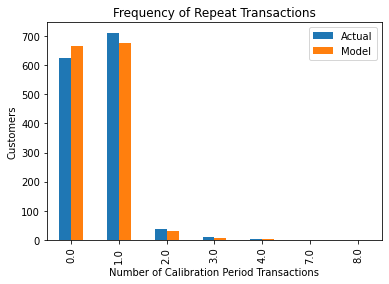

In [36]:
plot_period_transactions(bgf);

<Figure size 504x504 with 0 Axes>

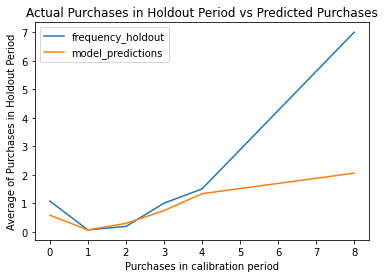

In [38]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch_2);

#### Evaluation functions

In [73]:
#function to return a df of real and predicted transacitons in eval period
def bgf_real_v_pred_df(ch,bgf):
    # transactions in the observation period equals frequency_holdout + 1
    rfm_cal_holdout = pd.DataFrame()
    ch_df = ch.df_ch_getdf()
    rfm_cal_holdout["n_transactions_cal_real"]  = ch_df["frequency_cal"] + 1
    rfm_cal_holdout["n_transactions_holdout_real"]  = ch_df["frequency_holdout"] + 1
    # the predicted number of transactions
    rfm_cal_holdout["n_transactions_holdout_pred"] = bgf.predict(t=ch.eval_period, 
                                                    frequency=ch_df['frequency_cal'], 
                                                    recency=ch_df['recency_cal'], 
                                                    T=ch_df['T_cal'])
    return rfm_cal_holdout[["n_transactions_cal_real","n_transactions_holdout_real", "n_transactions_holdout_pred"]]

In [64]:
#function to capture RMSE for a BGF model
def bgf_rmse(ch,bgf):
    df_ch = ch.df_ch_getdf()
    df_ch["n_transactions_holdout_real"] = df_ch["frequency_holdout"] + 1
    y_true = df_ch["n_transactions_holdout_real"]
    y_pred = bgf.predict(t=ch.eval_period, frequency=df_ch['frequency_cal'],
                         recency=df_ch['recency_cal'],
                         T=df_ch['T_cal'])

    return mean_squared_error(y_true,y_pred)

In [59]:
#function to return predicted # transactions for given customer in evaluation period
def samp_cust_pred_trans(df_ch,sample_customer_id,eval_period):
    sample_customer = df_ch.loc[sample_customer_id]
    n_transactions_pred = bgf.predict(t=eval_period,
                                  frequency=sample_customer['frequency_cal'], 
                                  recency=sample_customer['recency_cal'], 
                                  T=sample_customer['T_cal'])
    return(n_transactions_pred)